<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Titanic/blob/Auto-pipeline/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, I practice python with Titanic Dataset. Manual preprocessing of train and Test data (dropping, endoding categorical values, standardizing columns)


In [100]:
import pandas as pd
import numpy as np
from google.colab import drive

import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [82]:
def nan_percentage(df, colname):
  return (df[colname].isnull().sum() / df.shape[0]) * 100

def standardize_col(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

def remove_outliers(df, col):
  Q1 = np.quantile(df[col], 0.25)
  Q3 = np.quantile(df[col], 0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  print(f'lower = {lower}, upper = {upper}, IQR = {IQR}')

  # after filtering, keep only data within [lower, upper]
  filtered_vals = [x for x in df[col] if (x > lower) & (x < upper)]
  return df.loc[df[col].isin(filtered_vals)]

def nan_statistics(df):
  nan_cols = df.loc[:, df.isnull().any()].columns
  for col in nan_cols:
    print(f'Column {col} has {nan_percentage(df, col):.2f} % of Nans')
  print(df.isna().sum())

def nans_remain(df):
  return df.isnull().values.any()

In [83]:
# Setting file download from google Drive

drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/1.Titanic/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [84]:
train = pd.read_csv(train_path, index_col='PassengerId')
test = pd.read_csv(test_path, index_col='PassengerId')

In [85]:
# Step 1. General Summary
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [86]:
# Describe train data
# Already see Nans in Age, probably outliers in Age and other features
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [87]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
# Step 2. Check Nan values in any columns
nan_statistics(train)

Column Age has 19.87 % of Nans
Column Cabin has 77.10 % of Nans
Column Embarked has 0.22 % of Nans
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [89]:
# Found, that Cabin has 77% of Nans -> remove the column
# Age -> substitute with average / median
# Embarked -> substitute or remove column (depends on significancy)
# Name, Ticket -> can drop the column

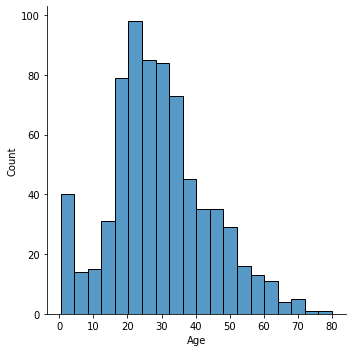

In [90]:
# Shapiro-Wilk test indicates, that 'Age' feature
# is from normal distribution -> we will use z-standartization
# for this feature
sns.displot(train, x='Age')

In [99]:
X = train.drop('Survived', axis=1)
Y = train['Survived']

In [117]:
column_transformer = make_column_transformer(
    ("drop", ['Name', 'Cabin', 'Ticket', 'Fare']),
    (KNNImputer(n_neighbors=3), ["Age"]),
    (SimpleImputer(strategy='most_frequent'), ['Embarked']),
    (OneHotEncoder(), ['Sex']),
    remainder='passthrough'
)

column_transformer_1 = make_column_transformer(
    (StandardScaler(), [0]), # Age
    (OneHotEncoder(), [1]), # Embarked
    remainder='passthrough'
)

feature_remover = VarianceThreshold(threshold=0.02)


In [107]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=3,
                                                    shuffle=True,
                                                    stratify=Y)

In [119]:
from sklearn.svm import SVC 

model1 = LogisticRegression()
model2 = SVC()

pipeline = make_pipeline(
    column_transformer,
    column_transformer_1,
    feature_remover,
    model2
)

param_grid = {
    
}

result = GridSearchCV(pipeline, param_grid, cv=5)
result.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer-1',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['Name',
                                                                          'Cabin',
                                                                          'Ticket',
                                                                          'Fare']),
                                           

In [120]:
result.best_score_

0.8187629272136314

In [123]:
best_model = result.best_estimator_
best_model.fit(X_train, Y_train)
pred = best_model.predict(test)

In [129]:
# Saving the submission data to csv file
submission = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': pred
})
submission.to_csv(gdrive_path + df_path + "submission.csv", index=False)